In [1]:
import pandas as pd
from aiohttp.helpers import SEPARATORS
from nltk import sent_tokenize, word_tokenize

from utils.io_utils import (get_absolute_path,
                            read_yaml)

In [2]:
# prepare variables from configuration file

config = read_yaml('../config.yml')
# path to the data source
data_path = get_absolute_path(config['data']['source'])

# name to sentence-transformers embeddings model
camembert_base_name = config['embedding_model']['camembert']['name']
camembert_base_path = config['embedding_model']['camembert']['model_path']

camembert_base_large_name = config['embedding_model']['camembert-large']['name']
camembert_base_large_path = config['embedding_model']['camembert-large']['model_path']

multilingual_base_name = config['embedding_model']['multilingual']['name']
multilingual_base_path = config['embedding_model']['multilingual']['model_path']

## Présentation du dataset

Ce dataset comprend les 3057 thèses disponibles sur le site [https://theses.chartes.psl.eu/](https://theses.chartes.psl.eu/) via un scrapper qui utilise l'API DoTS.

Modèle de données

---

- `text` : the text of the document that will be vectorized indexed. Each text row corresponding to a signifiant section of the document (e.g. introduction, chapters, conclusion, appendices, etc.) and corresponding to a first "semantic chunking" of the document.

and the metadata columns (important to retrieve and identify the document later):
- `unique_id` : the unique identifier of the document (e.g. "ENCPOS_2023_01_5"; "01": first thesis of the collection year 2023, "5": section 5 of the thesis)
- `file_id` : the identifier of the document (util for research in Web)
- `author` : the author of the document (positions de thèses)
- `section` : the section title of the document (e.g. introduction, chapters, conclusion, appendices, etc.)
- `title` : the title of the document
- `position_name` : the name of the position
- `year` : the year of the document
- `text_token_length` : the length of the text in tokens

In [3]:
# first analyze the data source
df = pd.read_csv(data_path, sep="\t", encoding="utf-8")
df.head()

,unique_id,file_id,year,author,position_name,section,text,text_token_length
0,ENCPOS_1849_01_1,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,I.,L’ insurrection de 1106 contre l’abbé Artaud a...,21
1,ENCPOS_1849_01_2,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,II.,La conspiration des bourgeois sous l’abbé Albé...,20
2,ENCPOS_1849_01_3,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,III.,"L’ insurrection communale proprement dite, ver...",13
3,ENCPOS_1849_01_4,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,IV.,L’origine de cette insurrection remonte à la r...,18
4,ENCPOS_1849_01_5,ENCPOS_1849_01,1849,Léon de Bastard d'Estang,Recherches sur l’origine et la nature des insu...,V.,"La commune, qui en est la suite, n’a qu’une ex...",25


## Retriever - Chunking method

La partie Retriever permet de retrouver des sections (snippets) intéressantes dans les documents en fonction d'une requête formulé par l'utilisateur. Ces sections ("chunks") sont ensuite indexées dans une base vectorielles pour permettre une retrouver les documents les plus proches de la requête de l'utilisateur.

Notre objectif consiste ici à répondre à la question : Comment on créer ces sections ("chunks") ? et quel taille devraient-elles faire ?

C'est une question complexe et ouverte qui peut nécéssiter plusieurs itérations, il n'y a pas de réponse unique.

Dans un premier temps nous allons analyser le dataset pour comprendre la longueur des textes et les sections qui le composent.

Aucune colonne n'a de valeurs manquantes.
Nombre de documents dans le dataset : 34050
Longueur maximale du texte en tokens : 2292
Longueur minimale du texte en tokens : 1
Longueur moyenne du texte en tokens : 200
Pourcentage de documents avec une longueur de texte < 100 tokens : 33.84%
Pourcentage de documents avec une longueur de texte < 200 tokens : 62.02%
Pourcentage de documents avec une longueur de texte entre 0 et 100 tokens : 34.16%
Pourcentage de documents avec une longueur de texte entre 100 et 200 tokens : 28.42%
Pourcentage de documents avec une longueur de texte entre 200 et 500 tokens : 31.76%
Pourcentage de documents avec une longueur de texte > 500 tokens : 6.21%
Nombre de documents avec une longueur de texte < 2 tokens : 7


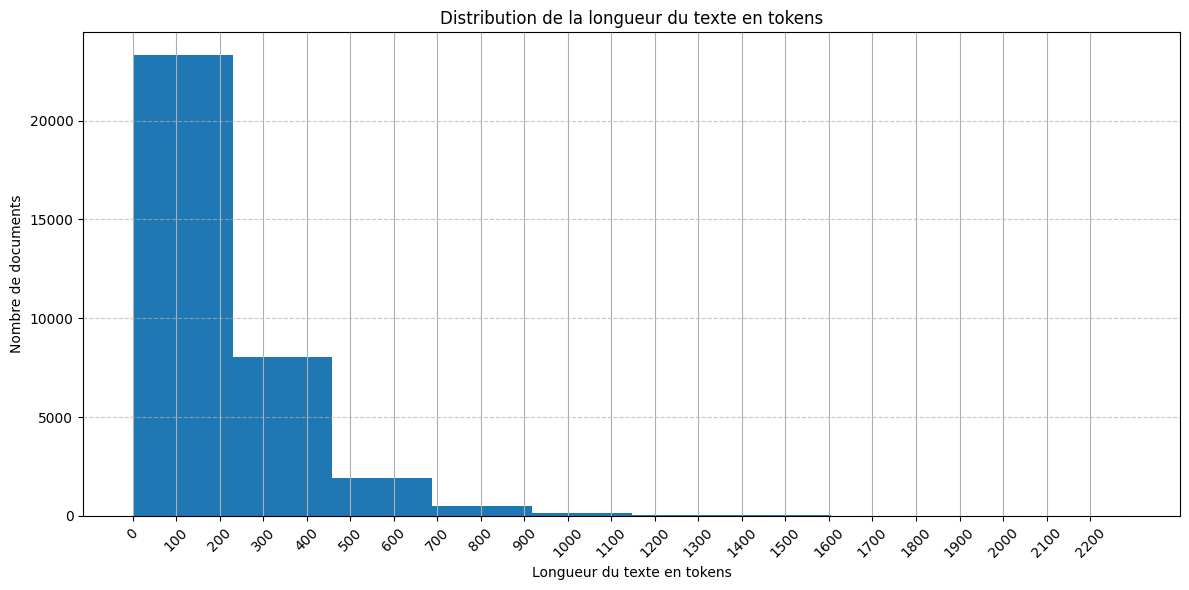

In [4]:
# First ensure the columns are in the right format
df['year'] = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype(int)
cols_to_str = ['file_id', 'unique_id', 'author', 'section', 'text', 'position_name']
df[cols_to_str] = df[cols_to_str].astype(str)

# check if columns are empty
empty_columns = df.columns[df.isnull().any()].tolist()
print(
    f"Les colonnes suivantes contiennent des valeurs manquantes : {empty_columns}" if empty_columns else "Aucune colonne n'a de valeurs manquantes."
)

# get max length of the text
max_text_token_length = df['text_token_length'].max()
min_text_token_length = df['text_token_length'].min()
mean_text_token_length = df['text_token_length'].mean()

print("Nombre de documents dans le dataset :", len(df))
print("Longueur maximale du texte en tokens :", max_text_token_length)
print("Longueur minimale du texte en tokens :", min_text_token_length)
print("Longueur moyenne du texte en tokens :", int(mean_text_token_length))

# get percentage of documents with text length < 100 tokens and < 200 tokens
percentage_less_100 = (df['text_token_length'] < 100).mean() * 100
percentage_less_200 = (df['text_token_length'] < 200).mean() * 100

print(f"Pourcentage de documents avec une longueur de texte < 100 tokens : {percentage_less_100:.2f}%")
print(f"Pourcentage de documents avec une longueur de texte < 200 tokens : {percentage_less_200:.2f}%")

# get percentage of documents with text length 0 <= tokens <= 100
percentage_0_to_100 = ((df['text_token_length'] >= 0) & (df['text_token_length'] <= 100)).mean() * 100
print(f"Pourcentage de documents avec une longueur de texte entre 0 et 100 tokens : {percentage_0_to_100:.2f}%")

# get percentage of documents with text length 100 <= tokens <= 200
percentage_100_to_200 = ((df['text_token_length'] >= 100) & (df['text_token_length'] <= 200)).mean() * 100
print(f"Pourcentage de documents avec une longueur de texte entre 100 et 200 tokens : {percentage_100_to_200:.2f}%")

# get percentage of documents with text length 200 <= tokens <= 500
percentage_200_to_500 = ((df['text_token_length'] >= 200) & (df['text_token_length'] <= 500)).mean() * 100
print(f"Pourcentage de documents avec une longueur de texte entre 200 et 500 tokens : {percentage_200_to_500:.2f}%")

# get percentage of documents with text length > 500 tokens
percentage_greater_500 = (df['text_token_length'] > 500).mean() * 100
print(f"Pourcentage de documents avec une longueur de texte > 500 tokens : {percentage_greater_500:.2f}%")

# nombre de documents avec une longueur de texte < 2
count_less_2 = (df['text_token_length'] < 2).sum()
print(f"Nombre de documents avec une longueur de texte < 2 tokens : {count_less_2}")

# create histogram of the text length (tokens and characters) side by side
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
df['text_token_length'].hist()
# add label on bars
plt.xticks(range(0, max_text_token_length + 1, 100), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Distribution de la longueur du texte en tokens')
plt.xlabel('Longueur du texte en tokens')
plt.ylabel('Nombre de documents')
plt.tight_layout()
plt.show()

# autre cellule : remove sentence with length < 2 tokens

Cette première analyse exploratoire du dataset nous permet de montrer :
La majortié des documents ont une longueur compris entre O et 100 tokens (environ 34% des documents). Il serait pertinents de s'intéroger sur la valeur sémantique des documents avec peu de tokens (le risque étant qu'un document de 2 tokens créer du bruit lors de la recherche à cause d'embeddings peu representatifs).

Regardons des exemples de textes avec moins de 2 à 4 tokens.

In [5]:
# get the sample documents with text length == 2 tokens
total_documents_exactly_2_tokens = df[df['text_token_length'] == 2].shape[0]
sample_less_equal_tokens = df[df['text_token_length'] == 2].sample(total_documents_exactly_2_tokens, random_state=42)

print(f"Nombre de documents avec une longueur de texte exactement 2 tokens : {total_documents_exactly_2_tokens}")
for i, row in sample_less_equal_tokens.iterrows():
    print(f"Document {i}: {row['text']}")

print("\n\n")

# get the sample documents with text length == 3 tokens
total_documents_exactly_3_tokens = df[df['text_token_length'] == 3].shape[0]
sample_less_equal_tokens = df[df['text_token_length'] == 3].sample(total_documents_exactly_3_tokens, random_state=42)
print(f"Nombre de documents avec une longueur de texte exactement 3 tokens : {total_documents_exactly_3_tokens}")
for i, row in sample_less_equal_tokens.iterrows():
    print(f"Document {i}: {row['text']}")

print("\n\n")

# get the sample documents with text length == 4 tokens
total_documents_exactly_4_tokens = df[df['text_token_length'] == 4].shape[0]
sample_less_equal_tokens = df[df['text_token_length'] == 4].sample(total_documents_exactly_4_tokens, random_state=42)
print(f"Nombre de documents avec une longueur de texte exactement 4 tokens : {total_documents_exactly_4_tokens}")
for i, row in sample_less_equal_tokens.iterrows():
    print(f"Document {i}: {row['text']}")


Nombre de documents avec une longueur de texte exactement 2 tokens : 15
Document 24150: Index. – Planches.
Document 25945: Glossaire. – Illustrations.
Document 247: Pièces justificatives.
Document 27342: (1911-1949)
Document 6707: Tableaux généalogiques.
Document 21133: Tableaux statistiques.
Document 4825: Sa fausseté.
Document 349: Pièces justificatives.
Document 31910: Lettres diverses.
Document 6300: Sources ; bibliographie.
Document 9169: Pièces justificatives.
Document 25449: Chronologie. – Index.
Document 26498: Index. ­ Glossaire.
Document 5978: Origines. Attributions.
Document 7603: 47 documents.



Nombre de documents avec une longueur de texte exactement 3 tokens : 38
Document 25143: Tableaux. – Cartes. – Photographies.
Document 31839: Cartes. — Tableaux chronologiques.
Document 3289: Subsistances et maximum.
Document 6976: Analyse du poème.
Document 24539: Tableaux. – Illustrations. – Index.
Document 21674: Table topo-onomastique.
Document 4047: Sceaux et Carte
Document 236

Cette analyse rapide nous montre que l'on peut éliminer les documents avec une longueur de texte inférieure à 4 tokens sans perdre une quantité importante d'information. En effet, ces documents sont souvent des titres ou des sections qui ne contiennent pas suffisamment d'informations pour être utiles dans le cadre de la recherche sémantique. en revanche, il est important de conserver les documents avec une longueur de texte supérieure à 4 tokens, car ils contiennent des informations plus riches et plus pertinentes comme des entités nommées qui peuvent être utiles de conserver.

Un autre aspect à prendre en compte est la longueur des tokens acceptés en entrée du modèle de transformation de phrases. En effet, les modèles de transformation de phrases ont une longueur maximale de tokens qu'ils peuvent traiter. Par exemple, le modèle CamemBERT base a une longueur maximale de 512 tokens, tandis que le modèle CamemBERT large a une longueur maximale de 1024 tokens. Il est donc important de s'assurer que les documents ne dépassent pas cette longueur maximale pour éviter des erreurs lors de l'indexation.

Pour notre indexation nous proposons d'utiliser 3 modèles de transformation de phrases :
- CamemBERT base
- CamemBERT large
- Multilingual base

In [ ]:
from sentence_transformers import SentenceTransformer

camembert_base_max_length = SentenceTransformer('Lajavaness/sentence-camembert-base').max_seq_length
camembert_large_max_length = SentenceTransformer('Lajavaness/sentence-camembert-large').max_seq_length
multilingual_max_length = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1').max_seq_length


print(f"CamemBERT base max length: {camembert_base_max_length}")
print(f"CamemBERT large max length: {camembert_large_max_length}")
print(f"Multilingual base max length: {multilingual_max_length}")

On peut voir ici que le nombre de tokens disponibles pour certaines sections de notre dataset excède la longueur maximale des modèles de transformation de phrases. Il est donc important de découper les sections en chunks plus petits pour éviter des erreurs lors de l'indexation.

### Stratégie pour découper les positions de thèses en chunks

nous proposons donc la méthode suivante pour découper les positions de thèses en chunks en partant de notre premier découpage sémantique des sections :

1- Éliminer les sections avec une longueur de texte strictement inférieure à 4 tokens (comme vu précédemment)

2- Si le texte est supérieur à la limite admise par le modèle on le découpe selon la limite de tokens du modèle cible (120)

3 - Évite d’avoir un dernier chunk très court (comme un 120 + 1)

4 - Retourne les chunks sous forme de liste (ou DataFrame si on l’applique à df)


In [12]:
import pandas as pd
from tqdm.notebook import tqdm
from langchain.text_splitter import RecursiveCharacterTextSplitter
from joblib import Parallel, delayed
from transformers import AutoTokenizer
import unicodedata

# Paramètres de découpe
CHUNK_SIZE = 512
CHUNK_OVERLAP = int(CHUNK_SIZE / 10)
print(f"Chunk size: {CHUNK_SIZE}, Chunk overlap: {CHUNK_OVERLAP}")
SEPARATORS = [
    "\n\n",
    ".",
    "!",
    "?",
    ";",
]

# Tokenizer CamemBERT
tokenizer = AutoTokenizer.from_pretrained(
    "Lajavaness/sentence-camembert-base",
    use_fast=True
)

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained("Lajavaness/sentence-camembert-base", use_fast=True),
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        add_start_index=True,
        strip_whitespace=True,
        #separators=SEPARATORS,
    )


def count_tokens(text: str) -> int:
    return len(tokenizer(text, add_special_tokens=False)["input_ids"])

def clean_text(text):
    text = " ".join(text.strip().split())
    return unicodedata.normalize("NFKC", text)

def process_row_recursive(row):
    text = clean_text(row["text"])
    title = f"{clean_text(row['position_name'])} : "
    len_title_token = count_tokens(title)

    raw_chunks = text_splitter.split_text(text)
    results = []

    for i, chunk in enumerate(raw_chunks):
        chunk_tokens = tokenizer(chunk, add_special_tokens=False)["input_ids"]
        total_tokens = len_title_token + len(chunk_tokens)

        # Si le chunk + titre dépasse la limite, on coupe intelligemment le chunk
        if total_tokens > CHUNK_SIZE:
            allowed_tokens = CHUNK_SIZE - len_title_token
            new_chunk_ids = chunk_tokens[:allowed_tokens]
            chunk = tokenizer.decode(new_chunk_ids, skip_special_tokens=True)

        full_chunk = f"{title}{chunk}".strip()
        results.append({
            "unique_id": row["unique_id"],
            "chunk_id": f"{row['unique_id']}_chunk_{i}",
            "file_id": row.get("file_id"),
            "author": row.get("author"),
            "position_name": clean_text(row.get("position_name")),
            "year": row.get("year"),
            "section": row.get("section"),
            "raw_chunk": chunk,
            "full_chunk": full_chunk,
            "full_chunk_characters_len": len(full_chunk),
            "full_chunk_token_len": count_tokens(full_chunk),
        })

    return results


# Chargement des données
df = pd.read_csv(data_path, sep="\t", encoding="utf-8")
df_temp = df[df['text_token_length'] >= 4].reset_index(drop=True)

# Traitement parallèle
results = Parallel(n_jobs=4)(
    delayed(process_row_recursive)(row) for _, row in tqdm(df_temp.iterrows(), total=len(df_temp))
)

# Mise à plat
flat_chunks = [item for sublist in results for item in sublist]
df_chunks = pd.DataFrame(flat_chunks)

# removed duplicates row based on 'text_chunk' and 'unique_id'
df_chunks = df_chunks.drop_duplicates(subset=['full_chunk', 'unique_id']).reset_index(drop=True)

# Export
#df_chunks.to_csv(f"../data/raw/encpos_chunked_tok_{CHUNK_SIZE}_{CHUNK_OVERLAP}.csv", sep="\t", encoding="utf-8", index=False)

Chunk size: 512, Chunk overlap: 51


  0%|          | 0/33989 [00:00<?, ?it/s]

Nombre de documents dans le dataset : 39416
Longueur maximale du texte en tokens : 512
Longueur minimale du texte en tokens : 11
Longueur moyenne du texte en tokens : 264


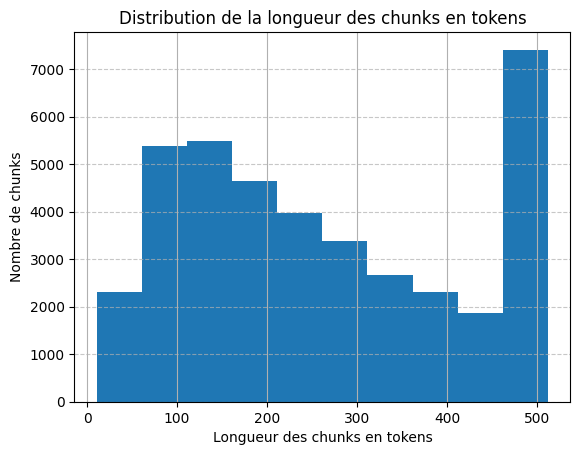

In [19]:
import matplotlib.pyplot as plt

max_text_token_length = df_chunks['full_chunk_token_len'].max()
min_text_token_length = df_chunks['full_chunk_token_len'].min()
mean_text_token_length = df_chunks['full_chunk_token_len'].mean()

print("Nombre de documents dans le dataset :", len(df_chunks))
print("Longueur maximale du texte en tokens :", max_text_token_length)
print("Longueur minimale du texte en tokens :", min_text_token_length)
print("Longueur moyenne du texte en tokens :", int(mean_text_token_length))

df_chunks['full_chunk_token_len'].hist()
plt.title('Distribution de la longueur des chunks en tokens')
plt.xlabel('Longueur des chunks en tokens')
plt.ylabel('Nombre de chunks')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
from nltk.tokenize import word_tokenize, sent_tokenize

text = "c. Disposition de la force publique. – Le roi convoque l’armée. A partir de la fin du règne de Clotaire I er , le service militaire tend à devenir une charge de propriété. Les officiers royaux des provinces, patrices, ducs, comtes, vicaires, centeniers, veillent à ce que le service militaire soit accompli par ceux qui les doivent ; les patrices, les ducs, les comtes, conduisent, quand il y a lieu, à l’armée les hommes du pays qu’ils administrent."

toks = word_tokenize(text, language='french')
print(toks)
print(len(toks))

['c', '.', 'Disposition', 'de', 'la', 'force', 'publique', '.', '–', 'Le', 'roi', 'convoque', 'l', '’', 'armée', '.', 'A', 'partir', 'de', 'la', 'fin', 'du', 'règne', 'de', 'Clotaire', 'I', 'er', ',', 'le', 'service', 'militaire', 'tend', 'à', 'devenir', 'une', 'charge', 'de', 'propriété', '.', 'Les', 'officiers', 'royaux', 'des', 'provinces', ',', 'patrices', ',', 'ducs', ',', 'comtes', ',', 'vicaires', ',', 'centeniers', ',', 'veillent', 'à', 'ce', 'que', 'le', 'service', 'militaire', 'soit', 'accompli', 'par', 'ceux', 'qui', 'les', 'doivent', ';', 'les', 'patrices', ',', 'les', 'ducs', ',', 'les', 'comtes', ',', 'conduisent', ',', 'quand', 'il', 'y', 'a', 'lieu', ',', 'à', 'l', '’', 'armée', 'les', 'hommes', 'du', 'pays', 'qu', '’', 'ils', 'administrent', '.']
100


In [17]:
text = "c. Disposition de la force publique. – Le roi convoque l’armée. A partir de la fin du règne de Clotaire I er , le service militaire tend à devenir une charge de propriété. Les officiers royaux des provinces, patrices, ducs, comtes, vicaires, centeniers, veillent à ce que le service militaire soit accompli par ceux qui les doivent ; les patrices, les ducs, les comtes, conduisent, quand il y a lieu, à l’armée les hommes du pays qu’ils administrent."

# apply tokenizer
encoding = tokenizer(text, add_special_tokens=False)
print(encoding)
print(len(encoding["input_ids"]))
# display tokens
toks = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
print(toks)

{'input_ids': [60, 9, 4194, 6937, 8, 13, 794, 1275, 9, 196, 54, 2012, 1113, 12034, 17, 12, 2677, 9, 114, 350, 8, 13, 259, 25, 5555, 8, 10476, 6956, 551, 21, 108, 21, 7, 16, 366, 2330, 4769, 15, 1090, 28, 688, 8, 1772, 9, 74, 12942, 21, 6287, 483, 20, 13314, 7, 387, 11789, 7, 18380, 10, 7, 11390, 10, 7, 21, 9553, 3206, 7, 2947, 35, 9722, 7, 2241, 113, 15, 44, 27, 16, 366, 2330, 191, 7109, 37, 320, 31, 19, 750, 167, 19, 387, 11789, 7, 19, 18380, 10, 7, 19, 11390, 10, 7, 21627, 7, 206, 51, 102, 33, 322, 7, 15, 17, 12, 2677, 19, 529, 25, 256, 46, 12, 240, 3874, 22364, 113, 9], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
120
['▁c', '.', '▁Dis', 'position', '▁de

In [ ]:
df_chunks

### Création de l'index vectoriel

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct, models
from sentence_transformers import SentenceTransformer
import uuid

# Load embedding model (français)
model = SentenceTransformer("Lajavaness/sentence-camembert-base")

data = "../data/documents_extracted_structured_prepared.csv"

# Charger le DataFrame à partir du fichier CSV
df = pd.read_csv(data, sep="\t", encoding="utf-8")
# just 10 data for qtesting
#df = df.head(10)

required_cols = ["text", "unique_id", "author", "section", "title", "text_length"]
missing = [col for col in required_cols if col not in df.columns]
if missing:
    raise ValueError(f"Missing columns : {missing}")

# Générer les vecteurs + ids
client = QdrantClient(path="../data/vectordb/qdrant.local."
                           "embedded")  # base locale persistée

client.create_collection(
    collection_name="encpos",
    vectors_config=VectorParams(
        size=model.get_sentence_embedding_dimension(),
        distance=Distance.COSINE
    )
)

vectors = model.encode(df["text"].tolist(), batch_size=64, show_progress_bar=True)

points = [
    models.PointStruct(
        id=str(uuid.uuid4()),
        vector=vec.tolist(),
        payload={
            "doc_id": row["unique_id"],
            "author": row["author"],
            "section": row["section"],
            "title": row["title"],
            "text": row["text"],
            "text_length": row["text_length"],
        }
    ) for vec, (_, row) in zip(vectors, df.iterrows())
]


# Indexer les points
status = client.upsert(collection_name="encpos", points=points, wait=True)

print(status)

print("✅ Indexation over with success.")

In [ ]:
collection_info = client.get_collection("encpos")
print("Nombre de points indexés :", collection_info.points_count)

In [ ]:
from llama_index.vector_stores.qdrant import QdrantVectorStore
from qdrant_client import QdrantClient

client = QdrantClient(path="../data/vectordb/qdrant.local."
                           "embedded")  # base locale persistée

vector_store = QdrantVectorStore(
    collection_name="encpos",
    client=client,
    vector_name=""
)

In [ ]:
from llama_index.core import Document, VectorStoreIndex, StorageContext
from llama_index.embeddings.langchain import LangchainEmbedding
from langchain_huggingface import HuggingFaceEmbeddings

embedding = LangchainEmbedding(HuggingFaceEmbeddings(model_name="Lajavaness/sentence-camembert-base"))

index = VectorStoreIndex.from_vector_store(
    vector_store=vector_store,
    embed_model=embedding,
)

# find the nearest neighbors
retriever = index.as_retriever(similarity_top_k=10)
nodes = retriever.retrieve("Comment les représentations iconographiques du roman arthurien ?")
for i, node in enumerate(nodes, start=1):
    print(i, ")", node.metadata['author'], node.metadata['title'], node.score)
    print()



In [ ]:
# Récupère tous les points de Qdrant
points = client.scroll(
    collection_name="encpos",
    scroll_filter=None,
    with_vectors=True,
    with_payload=True,
    limit=10000
)[0]

docs_processed = []
embeddings_vectors = []

for point in points:
    vector = point.vector
    metadata = point.payload
    text = metadata.get("text", "")  # ou "content", selon ton schéma
    doc = Document(text=text, metadata=metadata)
    docs_processed.append(doc)
    embeddings_vectors.append(vector)

In [ ]:
query = "Comment les représentations iconographiques du roman arthurien ?"
query_vector = embedding.get_text_embedding(query)

In [ ]:
import pacmap
import numpy as np
import umap.umap_ as umap



# Liste des vecteurs : documents + requête
embeddings_2d = np.array(embeddings_vectors + [query_vector])
embedding_projector = umap.UMAP(n_components=2, random_state=1)
documents_projected = embedding_projector.fit_transform(embeddings_2d)

In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": f"{docs_processed[i].metadata.get('author')}",
            "extract": docs_processed[i].metadata.get('title') + " : " + docs_processed[i].metadata.get('text')[:100] + "...",  # Limite d'extrait à 100 caractères
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data=["extract"],
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Positions de thèses embeddings via UMAP</b>",
    plot_bgcolor="white",   # Arrière-plan du graphe
)
fig.show()
